In [86]:
import pandas as pd
import datetime
import json

from catboost import CatBoostClassifier, Pool
import numpy as np

In [3]:
import psycopg2

conn = psycopg2.connect(
        user="ivanovo",
        password="ivanovo",
        host="92.51.39.188",  # локальный хост
        port="5432",       # стандартный порт PostgreSQL
        database="ivanovo"
    )

In [15]:
model = CatBoostClassifier(
    iterations=1000,         # Количество итераций (увеличьте при необходимости)
    # learning_rate=0.1,       # Скорость обучения
    depth=7,                 # Глубина деревьев
    loss_function='MultiClass', # Функция потерь
    cat_features=categorical_features,
    random_seed=42,
    verbose=100)
model.load_model('models/model_task1')
model

In [16]:
features = [
 'УНОМ',
 'month',
 'mean_volume1forhour',
 'std_volume1forhour',
 'mean_volume2forhour',
 'std_volume2forhour',
 'mean_q2forhour',
 'std_q2forhour',
 'min_volume1forhour',
 'max_volume1forhour',
 'median_volume1forhour',
 'min_volume2forhour',
 'max_volume2forhour',
 'median_volume2forhour',
 'min_q2forhour',
 'max_q2forhour',
 'median_q2forhour',
 'Потребители',
 'Группа',
 'Центральное отопление(контур)',
 'Ошибки',
 'weather1',
 'weather2',
 'Округ',
 'Район',
 'Серии проектов',
 'Количество этажей',
 'Количество подъездов',
 'Количество квартир',
 'Общая площадь',
 'Общая площадь жилых помещений',
 'Износ объекта (по БТИ)',
 'Материалы стен',
 'Признак аварийности здания',
 'Количество пассажирских лифтов',
 'Количество грузопассажирских лифтов',
 'Материалы кровли по БТИ',
 'Типы жилищного фонда',
 'Статусы МКД',
 'Марка счетчика ',
 'ЦТП',
 'Муниципальный округ',
 'Материал',
 'Назначение',
 'Класс',
 'Тип',
 'OBJ_TYPE',
 'Внутригородская территория',
 'Давление не в норме_count',
 'T < min_count',
 'T > max_count',
 'Утечка_count',
 'month1_count',
 'month2_count',
 'month3_count',
 'month4_count',
 'month10_count',
 'month11_count',
 'month12_count',
 'year',
 'day',
 'hour',
 'dayofweek',
 'weekofyear',
 'quarter',
 'is_month_start',
 'is_month_end',
 'month_sin',
 'month_cos',
 'hour_sin',
 'hour_cos',
 'quarter_sin',
 'quarter_cos',
 'day_sin',
 'day_cos',
 'dayofweek_sin',
 'dayofweek_cos',
 'weekofyear_sin',
 'weekofyear_cos'
]

In [17]:
features2aggdata = [
    "УНОМ",
    'Округ',
 'Район',
 'Серии проектов',
 'Количество этажей',
 'Количество подъездов',
 'Количество квартир',
 'Общая площадь',
 'Общая площадь жилых помещений',
 'Износ объекта (по БТИ)',
 'Материалы стен',
 'Признак аварийности здания',
 'Количество пассажирских лифтов',
 'Количество грузопассажирских лифтов',
 'Материалы кровли по БТИ',
 'Типы жилищного фонда',
 'Статусы МКД',
 'Марка счетчика ',
 'ЦТП',
 'Муниципальный округ',
 'Материал',
 'Назначение',
 'Класс',
 'Тип',
 'OBJ_TYPE',
 'Внутригородская территория',

]


In [18]:
categorical_features = [
 'УНОМ',
 'month',
 'Потребители',
 'Группа',
 'Центральное отопление(контур)',
 'Ошибки',
 'Округ',
 'Район',
 'Серии проектов',
 'Материалы стен',
 'Признак аварийности здания',
 'Материалы кровли по БТИ',
 'Типы жилищного фонда',
 'Статусы МКД',
 'Марка счетчика ',
 'ЦТП',
 'Муниципальный округ',
 'Материал',
 'Назначение',
 'Класс',
 'Тип',
 'OBJ_TYPE',
 'Внутригородская территория',
 'is_month_start',
'is_month_end'
           ]

In [32]:
%%time

def get_predict_for_all(model: CatBoostClassifier, date: datetime.datetime) -> dict: 

    conn = psycopg2.connect(
        user="ivanovo",
        password="ivanovo",
        host="92.51.39.188",  # локальный хост
        port="5432",       # стандартный порт PostgreSQL
        database="ivanovo"
    )
    
    agg_data = get_agg_data(conn)
    agg_data = agg_data.dropna(subset='unom')
    unomlst = agg_data['unom'].unique().tolist()
    n_preds = len(unomlst)
    events2preds = pd.DataFrame({
        "УНОМ": unomlst,
        "Дата создания во внешней системе": [date] * n_preds,
        "month": [date.month] * n_preds,
        "day": [date.day] * n_preds
    })
    
    odpu = get_odpu(date, conn)
    events2preds[ftrs2odpu] = events2preds.apply(lambda x: add_opdu_features(odpu, x), axis=1)

    with open('weather.json', 'r', encoding='utf-8') as file:
        weather = json.load(file)
    events2preds[['weather1', 'weather2']] = events2preds.apply(lambda x: collect_weather(x, weather), axis=1)

    events = get_events(date, conn)

    conn.close()
    events2preds[feature2events] = events2preds.apply(lambda x: collect_events(x, events), axis=1)
    agg_data['УНОМ'] = agg_data['unom']
    events2preds = events2preds.merge(agg_data[features2aggdata], how='left', on='УНОМ')

    
    events2preds = extract_datetime_features(events2preds, "Дата создания во внешней системе")
    events2preds = add_cyclic_features(events2preds, 'month', 12)
    events2preds = add_cyclic_features(events2preds, 'hour', 24)
    events2preds = add_cyclic_features(events2preds, 'quarter', 4)
    events2preds = add_cyclic_features(events2preds, 'day', 31)
    events2preds = add_cyclic_features(events2preds, 'dayofweek', 31)
    events2preds = add_cyclic_features(events2preds, 'weekofyear', 31)
    events2preds.drop("Дата создания во внешней системе", axis=1, inplace=True)
    

    numerical_features = [col for col in events2preds.columns if col not in categorical_features]
    
    # Удаление строк с NaN в числовых признаках
    events2preds[numerical_features] = events2preds[numerical_features].fillna(events2preds[numerical_features].mean())
    
    
    
    for col in categorical_features:
        events2preds[col] = events2preds[col].astype(str)
        
    preds = model.predict_proba(events2preds[features])
    events2preds['УНОМ'] = events2preds['УНОМ'].astype(float).astype(int)
    events2preds['preds'] = preds.tolist()
    
    return events2preds[['УНОМ', 'preds']].set_index('УНОМ')['preds'].to_dict()

# result_dict = get_predict_for_all(model, datetime.datetime(2023, 12, 1))
# result_dict

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 7.87 µs


In [33]:
def get_predict_for_one(model: CatBoostClassifier, unom: int, date: datetime.datetime) -> dict:
    conn = psycopg2.connect(
        user="ivanovo",
        password="ivanovo",
        host="92.51.39.188",  # локальный хост
        port="5432",       # стандартный порт PostgreSQL
        database="ivanovo"
    )
    
    agg_data = get_agg_data_one(unom, conn)
    events2preds = pd.DataFrame({
        "УНОМ": [unom],
        "Дата создания во внешней системе": [date],
        "month": [date.month],
        "day": [date.day]
    })

    odpu = get_odpu_one(unom, date, conn)
    events2preds[ftrs2odpu] = events2preds.apply(lambda x: add_opdu_features(odpu, x), axis=1)

    with open('weather.json', 'r', encoding='utf-8') as file:
        weather = json.load(file)
    events2preds[['weather1', 'weather2']] = events2preds.apply(lambda x: collect_weather(x, weather), axis=1)

    events = get_events_one(unom, date, conn)

    conn.close()
    events2preds[feature2events] = events2preds.apply(lambda x: collect_events(x, events), axis=1)
    agg_data['УНОМ'] = agg_data['unom']
    events2preds = events2preds.merge(agg_data[features2aggdata], how='left', on='УНОМ')

    
    events2preds = extract_datetime_features(events2preds, "Дата создания во внешней системе")
    events2preds = add_cyclic_features(events2preds, 'month', 12)
    events2preds = add_cyclic_features(events2preds, 'hour', 24)
    events2preds = add_cyclic_features(events2preds, 'quarter', 4)
    events2preds = add_cyclic_features(events2preds, 'day', 31)
    events2preds = add_cyclic_features(events2preds, 'dayofweek', 31)
    events2preds = add_cyclic_features(events2preds, 'weekofyear', 31)
    events2preds.drop("Дата создания во внешней системе", axis=1, inplace=True)
    

    numerical_features = [col for col in events2preds.columns if col not in categorical_features]
    
    # Удаление строк с NaN в числовых признаках
    events2preds[numerical_features] = events2preds[numerical_features].fillna(events2preds[numerical_features].mean())
    
    
    
    for col in categorical_features:
        events2preds[col] = events2preds[col].astype(str)
        
    preds = model.predict_proba(events2preds[features])
    
    return preds[0].tolist()


# result_dict = get_predict_for_one(model, 28413, datetime.datetime(2023, 12, 1))
# result_dict

In [21]:
ftrs2odpu = [
    'mean_volume1forhour',
    'std_volume1forhour',
    'mean_volume2forhour',
    'std_volume2forhour',
    'mean_q2forhour',
    'std_q2forhour',
    'min_volume1forhour',
    'max_volume1forhour',
    'median_volume1forhour',
    'min_volume2forhour',
    'max_volume2forhour',
    'median_volume2forhour',
    'min_q2forhour',
    'max_q2forhour',
    'median_q2forhour',
    'Потребители',
    'Группа',
    'Центральное отопление(контур)',
    'Ошибки'
]


def add_opdu_features(odpu, row):
    local_odpu = odpu[odpu['UNOM'] == row['УНОМ']]
    curr_time = row['Дата создания во внешней системе']
    local_odpu = local_odpu[local_odpu['Месяц/Год'] < curr_time]
    if len(local_odpu) > 14:
        local_odpu = local_odpu.iloc[-14:]

    for feature in ['volume1forhour', 'volume2forhour', 'q2forhour']:
        row[f'mean_{feature}'] = local_odpu[feature].mean()
        row[f'std_{feature}'] = local_odpu[feature].std()
        row[f'min_{feature}'] = local_odpu[feature].min()
        row[f'max_{feature}'] = local_odpu[feature].max()
        row[f'median_{feature}'] = local_odpu[feature].median()
    if len(local_odpu) > 0:
        row['Потребители'] = local_odpu['Потребители'].iloc[-1]
        row['Группа'] = local_odpu['Группа'].iloc[-1]
        row['Центральное отопление(контур)'] = local_odpu['Центральное отопление(контур)'].iloc[-1]
        row['Ошибки'] = local_odpu['Ошибки'].iloc[-1]
    else:
        row['Потребители'] = None
        row['Группа'] = None
        row['Центральное отопление(контур)'] = None
        row['Ошибки'] = None
    return row[ftrs2odpu]

    
def get_odpu(date:datetime.datetime, conn) -> pd.DataFrame: # возвращает таблицу odpu, ОБРЕЗАННУЮ ПО ДАТЕ 
    odpu = pd.read_sql(
       f"""
        SELECT
            *
        FROM 
            heating_data
        WHERE
            to_date(month_year, 'DD-MM-YYYY') BETWEEN to_date('{(date - pd.Timedelta(days=14)).strftime("%d-%m-%Y")}', 'DD-MM-YYYY')
            AND to_date('{date.strftime("%d-%m-%Y")}', 'DD-MM-YYYY')
        ;
        """, conn
    )
    odpu.rename(columns={
        'unom': 'UNOM',
        'id_uu': 'ID УУ',
        'id_tu': 'ID ТУ',
        'district': 'Округ',
        'area': 'Район',
        'consumers': 'Потребители',
        'group_type': 'Группа',
        'address': 'Адрес',
        'central_heating_contour': 'Центральное отопление(контур)',
        'meter_brand': 'Марка счетчика ',
        'meter_serial_number': 'Серия/Номер счетчика',
        'date': 'Дата',
        'month_year': 'Месяц/Год',
        'unit': 'Unit',
        'volume_supplied': 'Объём поданого теплоносителя в систему ЦО',
        'volume_returned': 'Объём обратного теплоносителя из системы ЦО',
        'difference_supply_return_mix': 'Разница между подачей и обраткой(Подмес)',
        'difference_supply_return_leak': 'Разница между подачей и обраткой(Утечка)',
        'temperature_supply': 'Температура подачи',
        'temperature_return': 'Температура обратки',
        'meter_operating_hours': 'Наработка часов счётчика',
        'heat_energy_consumption': 'Расход тепловой энергии',
        'errors': 'Ошибки'
    }, inplace=True)
    odpu['Месяц/Год'] = pd.to_datetime(odpu['Месяц/Год'], format='%d-%m-%Y')
    opdu = odpu[(odpu['Месяц/Год'] <= date) &
                (odpu['Месяц/Год'] >= date - pd.Timedelta(days=14))] 
    
    odpu.sort_values(by='Месяц/Год', inplace=True, ignore_index=True)
    odpu['Объём поданого теплоносителя в систему ЦО'] = odpu['Объём поданого теплоносителя в систему ЦО'].astype(float)
    odpu['volume1forhour'] = odpu['Объём поданого теплоносителя в систему ЦО'] / (odpu['Наработка часов счётчика'])
    odpu['volume2forhour'] = odpu['Объём обратного теплоносителя из системы ЦО'] / (odpu['Наработка часов счётчика'])
    odpu['q2forhour'] = odpu['Расход тепловой энергии'].astype(float) / (odpu['Наработка часов счётчика'])
    

    
    return odpu


def get_odpu_one(unom: int, date: datetime.datetime, conn):
    odpu = pd.read_sql(
       f"""
        SELECT
            *
        FROM 
            heating_data
        WHERE
            heating_data.unom = {unom}
            AND to_date(month_year, 'DD-MM-YYYY') BETWEEN to_date('{(date - pd.Timedelta(days=14)).strftime("%d-%m-%Y")}', 'DD-MM-YYYY')
            AND to_date('{date.strftime("%d-%m-%Y")}', 'DD-MM-YYYY')
        ;
        """, conn
    )
    odpu.rename(columns={
        'unom': 'UNOM',
        'id_uu': 'ID УУ',
        'id_tu': 'ID ТУ',
        'district': 'Округ',
        'area': 'Район',
        'consumers': 'Потребители',
        'group_type': 'Группа',
        'address': 'Адрес',
        'central_heating_contour': 'Центральное отопление(контур)',
        'meter_brand': 'Марка счетчика ',
        'meter_serial_number': 'Серия/Номер счетчика',
        'date': 'Дата',
        'month_year': 'Месяц/Год',
        'unit': 'Unit',
        'volume_supplied': 'Объём поданого теплоносителя в систему ЦО',
        'volume_returned': 'Объём обратного теплоносителя из системы ЦО',
        'difference_supply_return_mix': 'Разница между подачей и обраткой(Подмес)',
        'difference_supply_return_leak': 'Разница между подачей и обраткой(Утечка)',
        'temperature_supply': 'Температура подачи',
        'temperature_return': 'Температура обратки',
        'meter_operating_hours': 'Наработка часов счётчика',
        'heat_energy_consumption': 'Расход тепловой энергии',
        'errors': 'Ошибки'
    }, inplace=True)
    odpu['Месяц/Год'] = pd.to_datetime(odpu['Месяц/Год'], format='%d-%m-%Y')
    opdu = odpu[(odpu['Месяц/Год'] <= date) &
                (odpu['Месяц/Год'] >= date - pd.Timedelta(days=14))] 
    
    odpu.sort_values(by='Месяц/Год', inplace=True, ignore_index=True)
    odpu['Объём поданого теплоносителя в систему ЦО'] = odpu['Объём поданого теплоносителя в систему ЦО'].astype(float)
    odpu['volume1forhour'] = odpu['Объём поданого теплоносителя в систему ЦО'] / (odpu['Наработка часов счётчика'])
    odpu['volume2forhour'] = odpu['Объём обратного теплоносителя из системы ЦО'] / (odpu['Наработка часов счётчика'])
    odpu['q2forhour'] = odpu['Расход тепловой энергии'].astype(float) / (odpu['Наработка часов счётчика'])

    return odpu

In [22]:
get_odpu(datetime.datetime(2023, 12, 30), conn)

/tmp/ipykernel_48344/1458521846.py:51: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  odpu = pd.read_sql(


,UNOM,ID УУ,ID ТУ,Округ,Район,Потребители,Группа,Адрес,Центральное отопление(контур),Марка счетчика,...,Разница между подачей и обраткой(Подмес),Разница между подачей и обраткой(Утечка),Температура подачи,Температура обратки,Наработка часов счётчика,Расход тепловой энергии,Ошибки,volume1forhour,volume2forhour,q2forhour
0,3979,5009,8532,ВАО,Перово,"ГБУ ""ЖИЛИЩНИК РАЙОНА ПЕРОВО""",МКД,"1-я Владимирская ул., д. 8",ЦО1,КМ-5-2,...,1.15820,0.00000,90.54688,60.45536,23.99951,4.84338,,6.696182,6.744441,0.201812
1,2115193,1076015,833581238,ВАО,Богородское,"ГБПОУ ДЗМ ""МК №1""",Бюджет,"Ивантеевская ул., д. 25, к. 1",ТЭ1,ВИС.Т,...,0.92900,0.00000,108.67288,59.51379,24.00000,3.52538,,2.987708,3.026417,0.146891
2,2122249,93620,93650,ВАО,Ивановское,ГБОУ Школа № 1502,Бюджет,"ул. Молостовых, д. 10А",ЦО1,ТеРосс-ТМ,...,0.10156,0.00000,109.88886,82.36454,24.00000,8.56531,,12.895996,12.900228,0.356888
3,2403297,1073702,1073755,ВАО,Косино-Ухтомский,ГБОУ Школа № 2036,Бюджет,"ул. Руднёвка, д. 6",ЦО1,ВЗЛЕТ ТСРВ,...,0.00000,0.61726,104.60000,57.09000,24.00000,4.14823,,3.690016,3.664297,0.172843
4,2403296,1072493,1072655,ВАО,Косино-Ухтомский,ГБОУ Школа № 2036,Бюджет,"ул. Руднёвка, д. 10",ЦО1,КМ-5-2,...,0.10742,0.00000,107.69582,79.81343,24.00000,6.89075,,10.235840,10.240316,0.287115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9107,2404482,119836201,119838175,ВАО,Богородское,ГБОУ Школа № 1795,Бюджет,"3-я Богатырская ул., д. 5",ЦО1,АТ-Т-2,...,1.12500,0.00000,53.14500,49.41301,24.00000,1.67963,,18.727865,18.774740,0.069985
9108,2402235,10701,10777,ВАО,Богородское,ГБПОУ КИГМ № 23,Бюджет,"Погонный пр., д. 5 (Ввод 2)",ЦО2,КМ-5-2,...,0.00000,0.79492,55.50829,46.27532,24.00000,1.33792,,6.044434,6.011312,0.055747
9109,2121815,183304,183306,ВАО,Ивановское,ГБПОУ КЖГТ,Бюджет,"Напольный пр., д. 7",ЦО1,ВИС.Т,...,0.00000,0.27900,86.40711,58.76831,24.00000,4.66426,,7.030208,7.018583,0.194344
9110,2401528,39784,39792,ВАО,Косино-Ухтомский,"ГБУ ДО ""Московская Академия Хоккея""",Бюджет,"ул. Николая Старостина, д. 8",ЦО2,КМ-5-2,...,0.91260,0.00000,35.19033,32.67806,24.00000,0.13983,,2.248311,2.286336,0.005826


In [23]:
get_odpu_one(82024, datetime.datetime(2023, 12, 30), conn)

/tmp/ipykernel_48344/1458521846.py:104: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  odpu = pd.read_sql(


,UNOM,ID УУ,ID ТУ,Округ,Район,Потребители,Группа,Адрес,Центральное отопление(контур),Марка счетчика,...,Разница между подачей и обраткой(Подмес),Разница между подачей и обраткой(Утечка),Температура подачи,Температура обратки,Наработка часов счётчика,Расход тепловой энергии,Ошибки,volume1forhour,volume2forhour,q2forhour
0,82024,5005,16213,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,"Новокосинская ул., д. 12, к. 5",ЦО1,АТ-Т-2,...,0.0,0.97266,85.00236,52.05824,24.0,5.92920,,7.486410,7.445882,0.247050
1,82024,5005,16213,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,"Новокосинская ул., д. 12, к. 5",ЦО1,АТ-Т-2,...,0.0,0.88086,76.89833,47.33347,24.0,4.75610,,6.694580,6.657878,0.198171
2,82024,5005,16213,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,"Новокосинская ул., д. 12, к. 5",ЦО1,АТ-Т-2,...,0.0,0.89453,70.79049,45.31535,24.0,4.26093,,6.960856,6.923584,0.177539
3,82024,5005,16213,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,"Новокосинская ул., д. 12, к. 5",ЦО1,АТ-Т-2,...,0.0,0.87891,67.39267,43.83624,24.0,3.85962,,6.818929,6.782308,0.160818
4,82024,5005,16213,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,"Новокосинская ул., д. 12, к. 5",ЦО1,АТ-Т-2,...,0.0,0.86524,65.75852,42.87904,24.0,3.60053,,6.548828,6.512777,0.150022
5,82024,5005,16213,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,"Новокосинская ул., д. 12, к. 5",ЦО1,АТ-Т-2,...,0.0,0.92969,67.67542,46.06925,24.0,4.26135,,8.206950,8.168213,0.177556
6,82024,5005,16213,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,"Новокосинская ул., д. 12, к. 5",ЦО1,АТ-Т-2,...,0.0,0.98047,67.52190,47.88139,24.0,4.61701,,9.781006,9.740153,0.192375
7,82024,5005,16213,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,"Новокосинская ул., д. 12, к. 5",ЦО1,АТ-Т-2,...,0.0,0.83008,68.66834,46.46072,24.0,4.26172,,7.984945,7.950358,0.177572
8,82024,5005,16213,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,"Новокосинская ул., д. 12, к. 5",ЦО1,АТ-Т-2,...,0.0,0.94336,68.41111,47.69375,24.0,4.52759,,9.093262,9.053955,0.188650
9,82024,5005,16213,ВАО,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,"Новокосинская ул., д. 12, к. 5",ЦО1,АТ-Т-2,...,0.0,0.92578,70.54332,48.38593,24.0,4.72229,,8.868001,8.829427,0.196762


In [24]:
def get_agg_data(conn) -> pd.DataFrame:
    df = pd.read_sql_query(
        """ 
        SELECT *
        FROM buildings
        """, conn
    )
    new_column_names = {
        'external_system_address': 'Адрес из сторонней системы',
        'external_system_id': 'Идентификатор из сторонней системы',
        'bti_address': 'Адрес по БТИ',
        'unom': 'unom',
        'district': 'Округ',
        'area': 'Район',
        'project_series': 'Серии проектов',
        'number_of_floors': 'Количество этажей',
        'number_of_entrances': 'Количество подъездов',
        'number_of_apartments': 'Количество квартир',
        'total_area': 'Общая площадь',
        'total_residential_area': 'Общая площадь жилых помещений',
        'total_non_residential_area': 'Общая площадь нежилых помещений',
        'wear_and_tear_bti': 'Износ объекта (по БТИ)',
        'wall_materials': 'Материалы стен',
        'emergency_status': 'Признак аварийности здания',
        'number_of_passenger_elevators': 'Количество пассажирских лифтов',
        'number_of_freight_elevators': 'Количество грузопассажирских лифтов',
        'roof_cleaning_priority': 'Очередность уборки кровли',
        'roof_materials': 'Материалы кровли по БТИ',
        'housing_fund_types': 'Типы жилищного фонда',
        'mkd_statuses': 'Статусы МКД',
        'consumers': 'Потребители',
        'group_type': 'Группа',
        'central_heating': 'Центральное отопление(контур)',
        'meter_brand': 'Марка счетчика ',
        'meter_serial_number': 'Серия/Номер счетчика',
        'id_uu': 'ID УУ',
        'full_address': 'Полный адрес',
        'ods_number': '№ ОДС',
        'ods_address': 'Адрес ОДС',
        'ctp': 'ЦТП',
        'serial_number': '№ п/п',
        'city': 'Город',
        'administrative_district': 'Административный округ',
        'municipal_district': 'Муниципальный округ',
        'locality': 'Населенный пункт',
        'street': 'Улица',
        'house_number_type': 'Тип номера дом',
        'house_number': 'Номер дома',
        'building_number': 'Номер корпуса',
        'structure_number_type': 'Тип номера строения/сооружения',
        'structure_number': 'Номер строения',
        'unad': 'UNAD',
        'material': 'Материал',
        'purpose': 'Назначение',
        'class': 'Класс',
        'type': 'Тип',
        'sign': 'Признак',
        'global_id': 'global_id',
        'obj_type': 'OBJ_TYPE',
        'address_x': 'ADDRESS_x',
        'municipal_district_1': 'Муниципальный округ',
        'planning_element_name': 'Наименование элемента планировочной структуры или улично-дорожной сети',
        'house_ownership_number_type': 'Тип номера дома, владения, участка',
        'intra_city_area': 'Внутригородская территория',
        'adm_area': 'ADM_AREA',
        'district_1': 'DISTRICT',
        'nreg': 'NREG',
        'dreg': 'DREG',
        'n_fias': 'N_FIAS',
        'd_fias': 'D_FIAS',
        'kad_n': 'KAD_N',
        'kad_zu': 'KAD_ZU',
        'kladr': 'KLADR',
        'tdoc': 'TDOC',
        'ndoc': 'NDOC',
        'ddoc': 'DDOC',
        'adr_type': 'ADR_TYPE',
        'vid': 'VID',
        'sostad': 'SOSTAD',
        'status': 'STATUS',
        'geo_data': 'geoData',
        'geo_data_center': 'geodata_center',
        'id_ods': 'ID ODS',
        'phone_number': 'PHONE_NUMBER'
    }
    
    # Переименование столбцов
    df.rename(columns=new_column_names, inplace=True)
    return df

In [25]:
get_agg_data(conn)

/tmp/ipykernel_48344/3701048708.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(


,unom,ЦТП,Адрес из сторонней системы,Адрес по БТИ,Округ,Район,Серии проектов,Количество этажей,Количество подъездов,Количество квартир,...,VID,SOSTAD,STATUS,geoData,geodata_center,ID ODS,PHONE_NUMBER,energy_efficiency_class,phone_number_new,work_hours
0,23744,04-05-0602/019-1,"Дом по адресу РФ, г. Москва, вн.тер.г. м.о. Из...","город Москва, Сиреневый бульвар, дом 14, корпус 3",Восточный административный округ,муниципальный округ Измайлово,нет данных,5.0,3.0,60.0,...,Адрес,Зарегистрирован в АР,Внесён в ГКН,"[[[37.785483498, 55.801981742], [37.785515921,...","[37.785418079, 55.801745048]",143495450.0,8 (495) 539-53-53,C,+7 (901) 342-47-54,9:00 – 18:00
1,18744,04-05-0604/024-10,"Дом по адресу РФ, г. Москва, вн.тер.г. м.о. Из...","город Москва, 9-я Парковая улица, дом 50, корп...",Восточный административный округ,муниципальный округ Измайлово,нет данных,5.0,3.0,60.0,...,Адрес,Зарегистрирован в АР,Внесён в ГКН,"[[[37.800624269, 55.800754197], [37.800721977,...","[37.800636977, 55.800520274]",143495010.0,8 (495) 539-53-53,C,+7 (953) 186-64-43,9:00 - 21:00
2,18797,04-05-0604/124,"Дом по адресу РФ, г. Москва, вн.тер.г. м.о. Из...","город Москва, 11-я Парковая улица, дом 31",Восточный административный округ,муниципальный округ Измайлово,индивидуальный проект,5.0,3.0,50.0,...,Адрес,Зарегистрирован в АР,Внесён в ГКН,"[[[37.804883916, 55.798770842], [37.804908199,...","[37.804766469, 55.798475563]",143495010.0,8 (495) 539-53-53,C,+7 (841) 081-22-09,Круглосуточно
3,29878,04-06-0602/022-1,"Дом по адресу РФ, г. Москва, вн.тер.г. м.о. Се...","город Москва, Щёлковский проезд, дом 15, корпус 1",Восточный административный округ,муниципальный округ Северное Измайлово,нет данных,5.0,4.0,80.0,...,Адрес,Зарегистрирован в АР,Внесён в ГКН,"[[[37.776607821, 55.807923539], [37.777122111,...","[37.776791783, 55.80757833]",143494711.0,8 (495) 539-53-53,C,+7 (844) 433-32-42,9:00 - 21:00
4,8611,04-05-0604/076,"Дом по адресу РФ, г. Москва, вн.тер.г. м.о. Из...","город Москва, Измайловский бульвар, дом 16",Восточный административный округ,муниципальный округ Измайлово,I-515,17.0,1.0,112.0,...,Адрес,Зарегистрирован в АР,Внесён в ГКН,"[[[37.789088261, 55.796240557], [37.789208304,...","[37.789289488, 55.796201298]",143495450.0,8 (495) 539-53-53,C,+7 (619) 923-40-77,Круглосуточно
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4985,21175,04-05-0602/047,"Дом по адресу РФ, г. Москва, вн.тер.г. м.о. Из...","город Москва, 3-я Прядильная улица, дом 20",Восточный административный округ,муниципальный округ Измайлово,индивидуальный проект,5.0,3.0,46.0,...,Адрес,Зарегистрирован в АР,Внесён в ГКН,"[[[37.780127768, 55.797023269], [37.780181459,...","[37.780657375, 55.797035463]",143495450.0,8 (495) 539-53-53,C,+7 (591) 984-97-56,9:00 – 18:00
4986,8607,04-05-0604/139,"Дом по адресу РФ, г. Москва, вн.тер.г. м.о. Из...","город Москва, Измайловский бульвар, дом 3",Восточный административный округ,муниципальный округ Измайлово,нет данных,5.0,3.0,60.0,...,Адрес,Зарегистрирован в АР,Внесён в ГКН,"[[[37.784207067, 55.797805528], [37.78442426, ...","[37.783879913, 55.797720495]",143495450.0,8 (495) 539-53-53,C,+7 (953) 864-83-37,Круглосуточно
4987,18534,04-05-0602/064,"Дом по адресу РФ, г. Москва, вн.тер.г. м.о. Из...","город Москва, 3-я Парковая улица, дом 39, корп...",Восточный административный округ,муниципальный округ Измайлово,I-511,5.0,3.0,57.0,...,Адрес,Зарегистрирован в АР,Внесён в ГКН,"[[[37.779613713, 55.798685263], [37.779606574,...","[37.779736278, 55.798658527]",143495450.0,8 (495) 539-53-53,C,+7 (978) 982-06-79,9:00 – 18:00
4988,19237,04-05-0602/019-4,"Дом по адресу РФ, г. Москва, вн.тер.г. м.о. Из...","город Москва, Верхняя Первомайская улица, дом 21",Восточный административный округ,муниципальный округ Измайлово,нет данных,5.0,4.0,80.0,...,Адрес,Зарегистрирован в АР,Внесён в ГКН,"[[[37.78412074, 55.799922822], [37.78412157, 5...","[37.784023366, 55.799829278]",143495450.0,8 (495) 539-53-53,C,+7 (633) 900-51-05,Круглосуточно


In [26]:
def get_agg_data_one(unom: int, conn) -> pd.DataFrame:
    df = pd.read_sql_query(
        f""" 
        SELECT *
        FROM buildings
        WHERE buildings.unom = {unom}
        """, conn
    )
    new_column_names = {
        'external_system_address': 'Адрес из сторонней системы',
        'external_system_id': 'Идентификатор из сторонней системы',
        'bti_address': 'Адрес по БТИ',
        'unom': 'unom',
        'district': 'Округ',
        'area': 'Район',
        'project_series': 'Серии проектов',
        'number_of_floors': 'Количество этажей',
        'number_of_entrances': 'Количество подъездов',
        'number_of_apartments': 'Количество квартир',
        'total_area': 'Общая площадь',
        'total_residential_area': 'Общая площадь жилых помещений',
        'total_non_residential_area': 'Общая площадь нежилых помещений',
        'wear_and_tear_bti': 'Износ объекта (по БТИ)',
        'wall_materials': 'Материалы стен',
        'emergency_status': 'Признак аварийности здания',
        'number_of_passenger_elevators': 'Количество пассажирских лифтов',
        'number_of_freight_elevators': 'Количество грузопассажирских лифтов',
        'roof_cleaning_priority': 'Очередность уборки кровли',
        'roof_materials': 'Материалы кровли по БТИ',
        'housing_fund_types': 'Типы жилищного фонда',
        'mkd_statuses': 'Статусы МКД',
        'consumers': 'Потребители',
        'group_type': 'Группа',
        'central_heating': 'Центральное отопление(контур)',
        'meter_brand': 'Марка счетчика ',
        'meter_serial_number': 'Серия/Номер счетчика',
        'id_uu': 'ID УУ',
        'full_address': 'Полный адрес',
        'ods_number': '№ ОДС',
        'ods_address': 'Адрес ОДС',
        'ctp': 'ЦТП',
        'serial_number': '№ п/п',
        'city': 'Город',
        'administrative_district': 'Административный округ',
        'municipal_district': 'Муниципальный округ',
        'locality': 'Населенный пункт',
        'street': 'Улица',
        'house_number_type': 'Тип номера дом',
        'house_number': 'Номер дома',
        'building_number': 'Номер корпуса',
        'structure_number_type': 'Тип номера строения/сооружения',
        'structure_number': 'Номер строения',
        'unad': 'UNAD',
        'material': 'Материал',
        'purpose': 'Назначение',
        'class': 'Класс',
        'type': 'Тип',
        'sign': 'Признак',
        'global_id': 'global_id',
        'obj_type': 'OBJ_TYPE',
        'address_x': 'ADDRESS_x',
        'municipal_district_1': 'Муниципальный округ',
        'planning_element_name': 'Наименование элемента планировочной структуры или улично-дорожной сети',
        'house_ownership_number_type': 'Тип номера дома, владения, участка',
        'intra_city_area': 'Внутригородская территория',
        'adm_area': 'ADM_AREA',
        'district_1': 'DISTRICT',
        'nreg': 'NREG',
        'dreg': 'DREG',
        'n_fias': 'N_FIAS',
        'd_fias': 'D_FIAS',
        'kad_n': 'KAD_N',
        'kad_zu': 'KAD_ZU',
        'kladr': 'KLADR',
        'tdoc': 'TDOC',
        'ndoc': 'NDOC',
        'ddoc': 'DDOC',
        'adr_type': 'ADR_TYPE',
        'vid': 'VID',
        'sostad': 'SOSTAD',
        'status': 'STATUS',
        'geo_data': 'geoData',
        'geo_data_center': 'geodata_center',
        'id_ods': 'ID ODS',
        'phone_number': 'PHONE_NUMBER'
    }
    
    # Переименование столбцов
    df.rename(columns=new_column_names, inplace=True)
    return df

In [27]:

get_agg_data_one(82024, conn)

/tmp/ipykernel_48344/554794553.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(


,unom,ЦТП,Адрес из сторонней системы,Адрес по БТИ,Округ,Район,Серии проектов,Количество этажей,Количество подъездов,Количество квартир,...,VID,SOSTAD,STATUS,geoData,geodata_center,ID ODS,PHONE_NUMBER,energy_efficiency_class,phone_number_new,work_hours
0,82024,04-09-302,"Дом по адресу РФ, г. Москва, вн.тер.г. м.о. Но...","город Москва, Новокосинская улица, дом 12, кор...",Восточный административный округ,муниципальный округ Новокосино,П-3/16,17.0,2.0,136.0,...,Адрес,Зарегистрирован в АР,Внесён в ГКН,"[[[37.857500194, 55.736633236], [37.85771732, ...","[37.857673062, 55.736430968]",None,,C,+7 (951) 853-48-41,Круглосуточно


In [28]:
feature2events = [
    'Давление не в норме_count', 
    'T < min_count', 
    'T > max_count', 
    'Утечка_count', 
    'month1_count', 
    'month2_count', 
    'month3_count', 
    'month4_count', 
    'month10_count', 
    'month11_count', 
    'month12_count'
]

new_event_names = [
    'Давление не в норме',
    'T < min',
    'T > max',
    'Утечка'
]

def collect_events(row, events):
    local_events = events[events['УНОМ'] == row['УНОМ']]
    curr_time = row['Дата создания во внешней системе']
    local_events = local_events[local_events['Дата создания во внешней системе'] > curr_time]
    grpb = local_events.groupby('Наименование').count()['УНОМ']
    for event_type in new_event_names:
        if event_type in grpb:
            row[f'{event_type}_count'] = grpb[event_type]
        else:
            row[f'{event_type}_count'] = 0

    grpb = local_events.groupby('month').count()['Наименование']
    for month_num in [1,2,3,4,10,11,12]:
        if month_num in grpb:
            row[f"month{month_num}_count"] = grpb[month_num]
        else:
            row[f"month{month_num}_count"] = 0
    
    return row[feature2events]

In [29]:
num2month = {
    10: "october",
    11: "november",
    12: "december",
    1: "january",
    2: "february",
    3: "march",
    4: "april",
    5: "may",
    6: "june",
    7: "july",
    8: "august",
    9: "september"
}

def collect_weather(row, weather):
    mon = num2month[row.month]
    day = "{:02d}".format(row.day)
    row['weather1'], row['weather2'] = weather[mon][day]
    return row[['weather1', 'weather2']]

In [30]:
def get_events(date, conn) -> pd.DataFrame:
    events = pd.read_sql(
        f"""
        SELECT *
        FROM events
        WHERE 
            events.creation_date <= '{date.strftime("%Y-%m-%d")}'
            AND events.creation_date >= '2023-10-01'
        """, conn
    )
    events.rename(columns={
        'name': 'Наименование', 
        'source': 'Источник', 
        'creation_date': 'Дата создания во внешней системе', 
        'closure_date': 'Дата закрытия', 
        'district': 'Округ',
        'unom': 'УНОМ',
       'address': 'Адрес', 
        'event_completion_date': 'Дата и время завершения события'
    }, inplace=True)
    
    eventNames2labels = {
        "P1 <= 0": "Давление не в норме",
        "P2 <= 0": "Давление не в норме",
        "T1 > max": "T > max",
        "T1 < min": "T < min",
        "Недостаточная температура подачи в центральном отоплении (Недотоп)": "T < min",
        "Превышение температуры подачи в центральном отоплении (Перетоп)": "T > max",
        "Утечка теплоносителя": "Утечка",
        "Течь в системе отопления": "Утечка",
        "Температура в квартире ниже нормативной": "T < min",
        "Отсутствие отопления в доме": "T < min",
        "Сильная течь в системе отопления": "Утечка",
        "Температура в помещении общего пользования ниже нормативной": "T < min",
        "Аварийная протечка труб в подъезде": "Утечка",
        "Протечка труб в подъезде": "Утечка",
        "Температура в помещении общего пользования ниже нормативной": "T < min",
        "Отсутствие отопления в доме": "T < min",
        "Температура в квартире ниже нормативной": "T < min",
        "Течь в системе отопления": "Утечка",
        "Сильная течь в системе отопления": "Утечка",
    
    }
    
    event_names = list(eventNames2labels.keys())
    events = events[events['Наименование'].isin(event_names)]
    events['Наименование'] = events['Наименование'].apply(lambda x: eventNames2labels[x])
    events['Дата создания во внешней системе'] = pd.to_datetime(events['Дата создания во внешней системе'])
    events.sort_values(by='Дата создания во внешней системе', inplace=True, ignore_index=True)
    events['month'] = events['Дата создания во внешней системе'].apply(lambda x: x.month)
    events['day'] = events['Дата создания во внешней системе'].apply(lambda x: x.day)
    events = events[['Наименование', 'Источник', 'Дата создания во внешней системе', 'УНОМ', 'month', 'day']]

    return events


def get_events_one(unom: int, date: datetime.datetime, conn) -> pd.DataFrame:
    events = pd.read_sql(
        f"""
        SELECT *
        FROM events
        WHERE 
            events.creation_date <= '{date.strftime("%Y-%m-%d")}'
            AND events.creation_date >= '2023-10-01'
            AND unom = {unom}
        """, conn
    )
    events.rename(columns={
        'name': 'Наименование', 
        'source': 'Источник', 
        'creation_date': 'Дата создания во внешней системе', 
        'closure_date': 'Дата закрытия', 
        'district': 'Округ',
        'unom': 'УНОМ',
       'address': 'Адрес', 
        'event_completion_date': 'Дата и время завершения события'
    }, inplace=True)
    
    eventNames2labels = {
        "P1 <= 0": "Давление не в норме",
        "P2 <= 0": "Давление не в норме",
        "T1 > max": "T > max",
        "T1 < min": "T < min",
        "Недостаточная температура подачи в центральном отоплении (Недотоп)": "T < min",
        "Превышение температуры подачи в центральном отоплении (Перетоп)": "T > max",
        "Утечка теплоносителя": "Утечка",
        "Течь в системе отопления": "Утечка",
        "Температура в квартире ниже нормативной": "T < min",
        "Отсутствие отопления в доме": "T < min",
        "Сильная течь в системе отопления": "Утечка",
        "Температура в помещении общего пользования ниже нормативной": "T < min",
        "Аварийная протечка труб в подъезде": "Утечка",
        "Протечка труб в подъезде": "Утечка",
        "Температура в помещении общего пользования ниже нормативной": "T < min",
        "Отсутствие отопления в доме": "T < min",
        "Температура в квартире ниже нормативной": "T < min",
        "Течь в системе отопления": "Утечка",
        "Сильная течь в системе отопления": "Утечка",
    
    }
    
    event_names = list(eventNames2labels.keys())
    events = events[events['Наименование'].isin(event_names)]
    events['Наименование'] = events['Наименование'].apply(lambda x: eventNames2labels[x])
    events['Дата создания во внешней системе'] = pd.to_datetime(events['Дата создания во внешней системе'])
    events.sort_values(by='Дата создания во внешней системе', inplace=True, ignore_index=True)
    events['month'] = events['Дата создания во внешней системе'].apply(lambda x: x.month)
    events['day'] = events['Дата создания во внешней системе'].apply(lambda x: x.day)
    events = events[['Наименование', 'Источник', 'Дата создания во внешней системе', 'УНОМ', 'month', 'day']]

    return events

In [41]:
get_events_one(15109, datetime.datetime(2023, 12, 1), conn)

/tmp/ipykernel_15196/1255110072.py:58: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  events = pd.read_sql(


,Наименование,Источник,Дата создания во внешней системе,УНОМ,month,day
0,T < min,EDC,2023-10-01 05:41:02,15109,10,1
1,T < min,EDC,2023-10-01 05:41:02,15109,10,1
2,T < min,EDC,2023-10-01 05:41:14,15109,10,1
3,T < min,EDC,2023-10-01 05:41:14,15109,10,1
4,T < min,EDC,2023-10-08 09:39:05,15109,10,8
...,...,...,...,...,...,...
155,T < min,EDC,2023-11-20 09:20:13,15109,11,20
156,T < min,NG,2023-11-21 19:01:43,15109,11,21
157,T < min,NG,2023-11-21 19:01:43,15109,11,21
158,Утечка,EDC,2023-11-22 12:42:19,15109,11,22


In [40]:
def extract_datetime_features(df, date_col):
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['hour'] = df[date_col].dt.hour
    df['dayofweek'] = df[date_col].dt.dayofweek
    df['weekofyear'] = df[date_col].dt.isocalendar().week
    df['quarter'] = df[date_col].dt.quarter
    df['is_month_start'] = df[date_col].dt.is_month_start
    df['is_month_end'] = df[date_col].dt.is_month_end
    return df
    
    
def add_cyclic_features(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

In [61]:
date = datetime.datetime(2024, 4, 1)

conn = psycopg2.connect(
        user="ivanovo",
        password="ivanovo",
        host="92.51.39.188",  # локальный хост
        port="5432",       # стандартный порт PostgreSQL
        database="ivanovo"
    )
    
agg_data = get_agg_data(conn)
agg_data = agg_data.dropna(subset='unom')
unomlst = agg_data['unom'].unique().tolist()
n_preds = len(unomlst)
events2preds = pd.DataFrame({
    "УНОМ": unomlst,
    "Дата создания во внешней системе": [date] * n_preds,
    "month": [date.month] * n_preds,
    "day": [date.day] * n_preds
})

odpu = get_odpu(date, conn)
events2preds[ftrs2odpu] = events2preds.apply(lambda x: add_opdu_features(odpu, x), axis=1)

with open('configs/weather.json', 'r', encoding='utf-8') as file:
    weather = json.load(file)
events2preds[['weather1', 'weather2']] = events2preds.apply(lambda x: collect_weather(x, weather), axis=1)

events = get_events(date, conn)

conn.close()
events2preds[feature2events] = events2preds.apply(lambda x: collect_events(x, events), axis=1)
agg_data['УНОМ'] = agg_data['unom']
events2preds = events2preds.merge(agg_data[features2aggdata], how='left', on='УНОМ')


events2preds = extract_datetime_features(events2preds, "Дата создания во внешней системе")
events2preds = add_cyclic_features(events2preds, 'month', 12)
events2preds = add_cyclic_features(events2preds, 'hour', 24)
events2preds = add_cyclic_features(events2preds, 'quarter', 4)
events2preds = add_cyclic_features(events2preds, 'day', 31)
events2preds = add_cyclic_features(events2preds, 'dayofweek', 31)
events2preds = add_cyclic_features(events2preds, 'weekofyear', 31)
events2preds.drop("Дата создания во внешней системе", axis=1, inplace=True)


numerical_features = [col for col in events2preds.columns if col not in categorical_features]

# Удаление строк с NaN в числовых признаках
events2preds[numerical_features] = events2preds[numerical_features].fillna(events2preds[numerical_features].mean())



for col in categorical_features:
    events2preds[col] = events2preds[col].astype(str)
    
preds = model.predict_proba(events2preds[features])
preds

/tmp/ipykernel_48344/3701048708.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(
/tmp/ipykernel_48344/1458521846.py:51: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  odpu = pd.read_sql(
/tmp/ipykernel_48344/1255110072.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  events = pd.read_sql(
/tmp/ipykernel_48344/1439832028.py:50: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None

array([[0.33572747, 0.01452291, 0.00508668, 0.55051852, 0.09414442],
       [0.35314374, 0.01799896, 0.00527349, 0.54618876, 0.07739505],
       [0.34314531, 0.01664249, 0.00435684, 0.5355582 , 0.10029717],
       ...,
       [0.34634033, 0.01616672, 0.00775933, 0.55138344, 0.07835018],
       [0.32358192, 0.02058785, 0.00984289, 0.58031243, 0.06567491],
       [0.31887685, 0.01649844, 0.00407976, 0.57422529, 0.08631966]])

In [55]:
preds = model.predict_proba(events2preds[features])
preds[0]

array([0.28819364, 0.04373768, 0.00630583, 0.46289191, 0.19887094])

In [76]:
events2preds[features]

,УНОМ,month,mean_volume1forhour,std_volume1forhour,mean_volume2forhour,std_volume2forhour,mean_q2forhour,std_q2forhour,min_volume1forhour,max_volume1forhour,...,hour_sin,hour_cos,quarter_sin,quarter_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos,weekofyear_sin,weekofyear_cos
0,23744,4,inf,0.876392,inf,0.903747,0.084297,0.01372,6.012964,inf,...,0.0,1.0,1.224647e-16,-1.0,0.201299,0.97953,0.0,1.0,0.299363,-0.954139
1,18744,4,inf,0.876392,inf,0.903747,0.084297,0.01372,6.012964,inf,...,0.0,1.0,1.224647e-16,-1.0,0.201299,0.97953,0.0,1.0,0.299363,-0.954139
2,18797,4,inf,0.876392,inf,0.903747,0.084297,0.01372,6.012964,inf,...,0.0,1.0,1.224647e-16,-1.0,0.201299,0.97953,0.0,1.0,0.299363,-0.954139
3,29878,4,inf,0.876392,inf,0.903747,0.084297,0.01372,6.012964,inf,...,0.0,1.0,1.224647e-16,-1.0,0.201299,0.97953,0.0,1.0,0.299363,-0.954139
4,8611,4,inf,0.876392,inf,0.903747,0.084297,0.01372,6.012964,inf,...,0.0,1.0,1.224647e-16,-1.0,0.201299,0.97953,0.0,1.0,0.299363,-0.954139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4985,21175,4,inf,0.876392,inf,0.903747,0.084297,0.01372,6.012964,inf,...,0.0,1.0,1.224647e-16,-1.0,0.201299,0.97953,0.0,1.0,0.299363,-0.954139
4986,8607,4,inf,0.876392,inf,0.903747,0.084297,0.01372,6.012964,inf,...,0.0,1.0,1.224647e-16,-1.0,0.201299,0.97953,0.0,1.0,0.299363,-0.954139
4987,18534,4,inf,0.876392,inf,0.903747,0.084297,0.01372,6.012964,inf,...,0.0,1.0,1.224647e-16,-1.0,0.201299,0.97953,0.0,1.0,0.299363,-0.954139
4988,19237,4,inf,0.876392,inf,0.903747,0.084297,0.01372,6.012964,inf,...,0.0,1.0,1.224647e-16,-1.0,0.201299,0.97953,0.0,1.0,0.299363,-0.954139


In [87]:
pol = Pool(data=events2preds[features], cat_features=categorical_features)

In [103]:
shap_values[:, :, 0]

array([[-0.36292299, -0.20860353,  0.00517184, ..., -0.01799577,
         0.02899822,  0.02724476],
       [-0.3511541 , -0.19289708,  0.01417355, ..., -0.00620757,
         0.03676305,  0.02702671],
       [-0.36402774, -0.18400899, -0.00398987, ..., -0.01799577,
         0.03146462,  0.02552787],
       ...,
       [-0.35782932, -0.18130864,  0.00500674, ..., -0.01799577,
         0.02796848,  0.01165874],
       [-0.37426254, -0.20216927, -0.00382477, ..., -0.01799577,
         0.03544628,  0.01957314],
       [-0.36621632, -0.21951263,  0.00517184, ..., -0.01799577,
         0.02541287,  0.02724476]])

/home/daniil/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


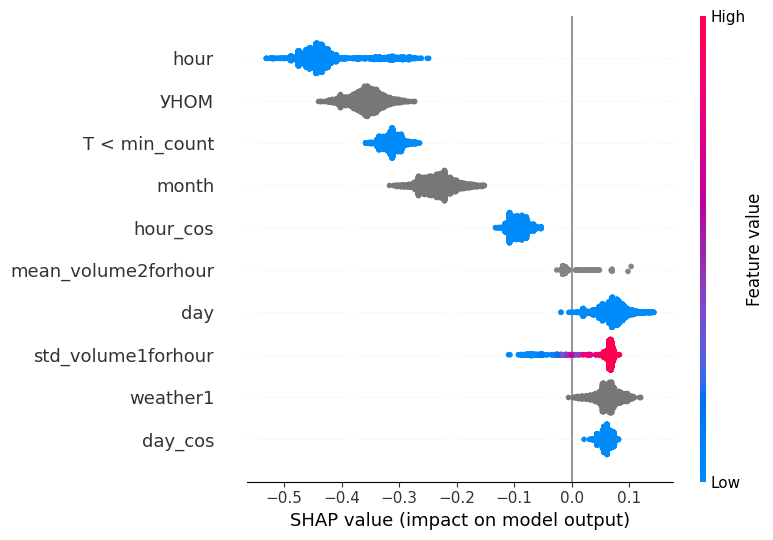

In [112]:
import shap

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(pol)[:, :, 0]
shap.summary_plot(shap_values, events2preds[features], feature_names=events2preds[features].columns, max_display=10)